In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
import imutils
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/GRI/plant_diseases.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [4]:

print(len(os.listdir('/content/potato blight')))
print(len(os.listdir('/content/corn leaf')))


30
30


In [5]:
try:
    os.mkdir('/content/accdetection')
    os.mkdir('/content/accdetection/training')
    os.mkdir('/content/accdetection/testing')

    os.mkdir('/content/accdetection/training/corn leaf blight')
    os.mkdir('/content/accdetection/training/potato early blight')
  


    os.mkdir('/content/accdetection/testing/corn leaf blight')
    os.mkdir('/content/accdetection/testing/potato early blight')
    
except OSError:
    pass

In [6]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


Class1_SOURCE_DIR = "/content/corn leaf/"
TRAINING_Class1_DIR = "/content/accdetection/training/corn leaf blight/"
TESTING_Class1_DIR = "/content/accdetection/testing/corn leaf blight/"

Class2_SOURCE_DIR = "/content/potato blight/"
TRAINING_Class2_DIR = "/content/accdetection/training/potato early blight/"
TESTING_Class2_DIR = "/content/accdetection/testing/potato early blight/"




split_size = 0.9
split_data(Class1_SOURCE_DIR, TRAINING_Class1_DIR, TESTING_Class1_DIR, split_size)
split_data(Class2_SOURCE_DIR, TRAINING_Class2_DIR, TESTING_Class2_DIR, split_size)




In [7]:
TRAINING_DIR = "/content/accdetection/training"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/content/accdetection/testing"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 54 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 100)       90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dropout (Dropout)            (None, 129600)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                6

In [9]:
opt=tf.keras.optimizers.Adam(lr=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])


history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=200,
            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
1/1 [==============================] - 33s 33s/step - loss: 0.7021 - acc: 0.4815 - val_loss: 1.2583 - val_acc: 0.5000
Epoch 2/200
1/1 [==============================] - 0s 489ms/step - loss: 1.1042 - acc: 0.5000 - val_loss: 4.1135 - val_acc: 0.5000
Epoch 3/200
1/1 [==============================] - 0s 484ms/step - loss: 3.7121 - acc: 0.5000 - val_loss: 2.1315 - val_acc: 0.5000
Epoch 4/200
1/1 [==============================] - 0s 480ms/step - loss: 1.9557 - acc: 0.5000 - val_loss: 0.8906 - val_acc: 0.5000
Epoch 5/200
1/1 [==============================] - 0s 493ms/step - loss: 0.8625 - acc: 0.5000 - val_loss: 0.7008 - val_acc: 0.5000
Epoch 6/200
1/1 [==============================] - 1s 539ms/step - loss: 0.6965 - acc: 0.5000 - val_loss: 0.6923 - val_acc: 0.3333
Epoch 7/200
1/1 [==============================] - 1s 514ms/step - loss: 0.6923 - acc: 0.4259 - val_loss: 0.6927 - val_acc: 0.6667
Epoch 8/200
1/1 [==============================] - 1s 502ms/step - loss: 0.6889 - ac

In [10]:
model.evaluate(validation_generator)

1/1 [==============================] - 0s 45ms/step - loss: 1.1877 - acc: 0.5000


[1.1876821517944336, 0.5]

In [11]:
model.save('Plants.h5')

In [17]:
from keras.preprocessing.image import load_img,img_to_array

dic=train_generator.class_indices

icd={k:v for v,k in dic.items()}

def output(location):

    img=load_img(location,target_size=(150,150,3))

    img=img_to_array(img)

    img=img/255

    img=np.expand_dims(img,[0])

    answer=model.predict_classes(img)

    probability=round(np.max(model.predict_proba(img)*100),2)
    print ("**",icd[answer[0]], 'With probability',probability,"\n")

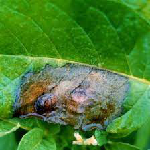

In [18]:
img="/content/potato blight/p (1).jpg"
s=load_img(img,target_size=(150,150,3))
s


In [19]:
output(img)

** potato early blight With probability 100.0 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
